In [1]:
FILENAME    = 'tari_test.yaml'
DXL_ID      = [1, 14, 20]
TEST_NUMBER = len(DXL_ID)
Q_PROP      = 0.5
DT_MS       = 300

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import yaml

/home/dhonan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


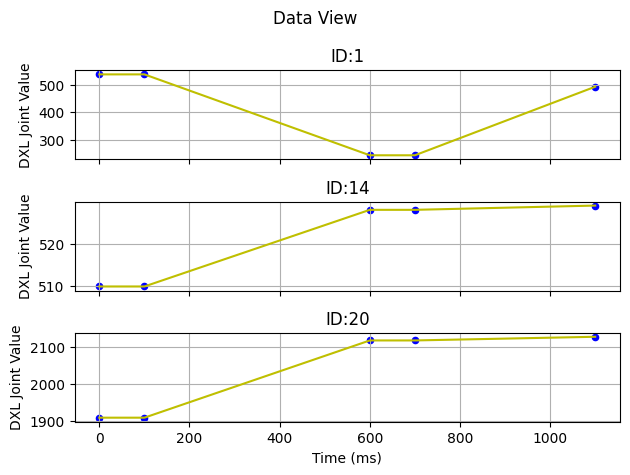

In [3]:
angle   = []
time    = []
with open(FILENAME, 'r') as file:
    yaml_file = yaml.safe_load(file)
    for dxl_id in DXL_ID:
        angle.append(yaml_file[dxl_id]['angle'])
        time.append(yaml_file[dxl_id]['time'])

fig, ax = plt.subplots(TEST_NUMBER, 1, sharex=True)

for i in range(TEST_NUMBER):
    ax[i].plot(time[i], angle[i], c='y')
    ax[i].scatter(time[i], angle[i], s=20, c='b')
    ax[i].set_title(f'ID:{DXL_ID[i]}')
    ax[i].set_ylabel('DXL Joint Value')
    ax[i].grid()
    if i == TEST_NUMBER - 1:
        ax[i].set_xlabel('Time (ms)')

fig.suptitle('Data View')
fig.tight_layout()
plt.show()

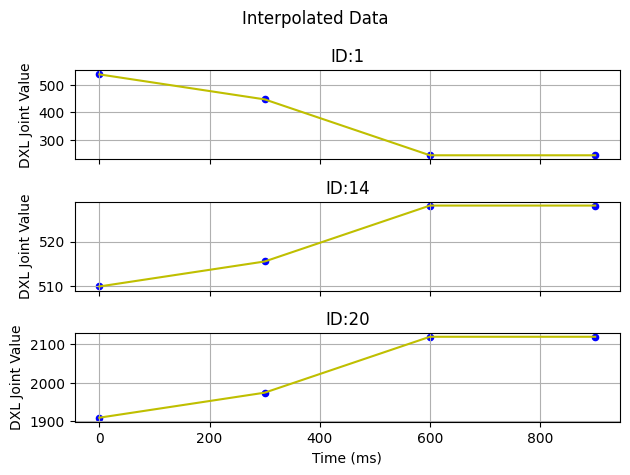

In [4]:
def calculateS(tk0:float, tk0p:float, tk1m:float, tk1:float, tau:float) -> float:
    c1 = -tk0 + 3*tk0p - 3*tk1m + tk1
    c2 = 3*tk0 - 6*tk0p + 3*tk1m
    c3 = -3*tk0 + 3*tk0p
    c4 = tk0 - tau

    s_n = 0.5
    for i in range(10):
        f_val       = c1*(s_n**3.0) + c2*(s_n**2.0) + c3*s_n + c4
        f_dot_val   = 3.0*c1*(s_n**2.0) + 2.0*c2*s_n + c3
        s_n         = s_n - f_val/f_dot_val

    return s_n



def bezierInterpolate(angle:list, time_ms:list, q_proportion:float, dt_ms:float) -> tuple:
    if len(angle) != len(time_ms): raise Exception('"angle" and "time" lists length must be the same')

    num_data    = len(angle)
    timestamp   = list(np.arange(time_ms[0], time_ms[-1], dt_ms))
    tau_plus    = []
    tau_min     = []

    for i in range(num_data):
        if i == 0: continue
        tau_plus.append(time_ms[i - 1] + (time_ms[i] - time_ms[i - 1])*q_proportion)
        tau_min.append(time_ms[i - 1] + (time_ms[i] - time_ms[i - 1])*(1.0 - q_proportion))

    angle_res   = []
    idx         = 1
    for t in timestamp:
        if t > time_ms[idx]: idx += 1
        
        s_val = calculateS(
            time_ms[idx - 1], 
            tau_plus[idx - 1], 
            tau_min[idx - 1], 
            time_ms[idx], 
            t
        )

        angle_res.append(
            ((1.0 - s_val)**3.0)*angle[idx - 1] + 
            (3.0*s_val*(1.0 - s_val)**2.0)*angle[idx - 1] + 
            (3.0*(s_val**2.0)*(1.0 - s_val))*angle[idx] + 
            (s_val**3.0)*angle[idx]
        )

    return angle_res, timestamp



angle_res   = []
time_res    = []
for i in range(TEST_NUMBER):
    res_angle, res_time = bezierInterpolate(
        angle           = angle[i],
        time_ms         = time[i],
        q_proportion    = Q_PROP,
        dt_ms           = DT_MS
    )
    angle_res.append(res_angle)
    time_res.append(res_time)



fig, ax = plt.subplots(TEST_NUMBER, 1, sharex=True)

for i in range(TEST_NUMBER):
    ax[i].plot(time_res[i], angle_res[i], c='y')
    ax[i].scatter(time_res[i], angle_res[i], s=20, c='b')
    ax[i].set_title(f'ID:{DXL_ID[i]}')
    ax[i].set_ylabel('DXL Joint Value')
    ax[i].grid()
    if i == TEST_NUMBER - 1:
        ax[i].set_xlabel('Time (ms)')

fig.suptitle('Interpolated Data')
fig.tight_layout()
plt.show()